In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP 

from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt

### Utils

In [2]:
def plot_2d(df: pd.DataFrame):
	fig = px.scatter(df, x="pc1", y="pc2", color="cluster", opacity=0.5, color_discrete_sequence=px.colors.qualitative.Plotly)

	return fig

def plot_3d(df: pd.DataFrame):
	fig = px.scatter_3d(df, x="pc1", y="pc2", z="pc3", color="cluster", opacity=0.5, color_discrete_sequence=px.colors.qualitative.Plotly)
	return fig

#### Config

In [3]:
from enum import Enum 

class DATASET(Enum):
	CELEBA_L = "celeba_buffalo_l"
	CELEBA_S = "celeba_buffalo_s"

class DATA_CATEGORY(Enum):
	FEATURES = "features"
	EMBEDDINGS = "embeddings"

class PROJECTION(Enum):
	UMAP = "umap"
	TSNE = "tsne_exaggeration_12"

In [4]:
dataset = pd.read_parquet(f"../data/{DATASET.CELEBA_L.value}__{DATA_CATEGORY.EMBEDDINGS.value}.gzip")
data_projected = np.load(f"../precomputed/{DATASET.CELEBA_L.value}__{DATA_CATEGORY.EMBEDDINGS.value}_{PROJECTION.TSNE.value}.npy")
data_projected = pd.DataFrame(data_projected, columns=["pc1", "pc2", "pc3"])

data_projected.head()

pc1        pc2        pc3
0  15.037194 -13.202821  10.617456
1  14.187559 -15.544608  23.651932
2 -17.481544 -22.274235   8.914062
3 -21.575413  15.985170  -4.425705
4 -31.851103  -9.754775 -10.589564

#### KMeans

In [13]:
features = pd.read_parquet(f"../data/{DATASET.CELEBA_L.value}__{DATA_CATEGORY.FEATURES.value}.gzip")
embeddings = pd.read_parquet(f"../data/{DATASET.CELEBA_L.value}__{DATA_CATEGORY.EMBEDDINGS.value}.gzip")

In [15]:
# fast way
features = features - features.mean()
embeddings = embeddings - embeddings.mean()

corr = features.T.dot(embeddings).div(len(features)).div(embeddings.std(ddof=0)).div(features.std(ddof=0), axis=0)

In [16]:
corr

embedding_0  embedding_1  embedding_2  embedding_3  \
5_o_Clock_Shadow       -0.027858    -0.040178     0.030860    -0.003789   
Arched_Eyebrows         0.041730     0.048865    -0.033740    -0.016564   
Bags_Under_Eyes         0.008085    -0.048402     0.022694    -0.040729   
Bald                    0.013992    -0.017923    -0.022190    -0.028661   
Bangs                   0.021150    -0.034492     0.006276     0.037042   
Big_Lips                0.009680     0.020562     0.024555    -0.015191   
Big_Nose                0.006847    -0.040254     0.049178    -0.004456   
Black_Hair             -0.088502    -0.037735     0.051138     0.025268   
Blond_Hair              0.126922     0.057542     0.003661     0.000815   
Blurry                  0.000128    -0.018377    -0.010443     0.020332   
Brown_Hair             -0.009837    -0.002450    -0.024038    -0.022567   
Bushy_Eyebrows         -0.016091    -0.039449     0.009728     0.008602   
Chubby                  0.008750    -0.034894    -0.006918    -0.005663   
Double_Chin             0.005552    -0.042409     0.000292    -0.030074   
Eyeglasses             -0.020596    -0.009675    -0.012481     0.004103   
Goatee                 -0.007846    -0.010930    -0.002907    -0.020230   
Gray_Hair              -0.001750    -0.025711     0.005436    -0.067519   
Heavy_Makeup            0.041166     0.082363    -0.031220     0.013449   
High_Cheekbones         0.062982     0.025714     0.029166     0.002408   
Male                   -0.036548    -0.072635     0.035685    -0.038400   
Mouth_Slightly_Open     0.046134     0.013677     0.008395     0.009092   
Mustache                0.010750    -0.011652    -0.020347    -0.017500   
Narrow_Eyes             0.016106     0.001306     0.014933     0.011285   
No_Beard                0.032705     0.036945    -0.016280     0.017024   
Oval_Face               0.047557     0.045790    -0.048819    -0.014311   
Pale_Skin               0.011469    -0.002244    -0.010623    -0.004104   
Pointy_Nose             0.002106     0.048291     0.024816     0.010136   
Receding_Hairline      -0.003557    -0.019292    -0.011484    -0.017091   
Rosy_Cheeks             0.040010     0.022143     0.015198     0.017931   
Sideburns              -0.019713    -0.019067     0.036100    -0.035382   
Smiling                 0.062850     0.009357     0.036650    -0.009346   
Straight_Hair          -0.007892    -0.024004     0.006280    -0.019394   
Wavy_Hair               0.015094     0.043232    -0.023973    -0.002068   
Wearing_Earrings        0.053733     0.027911    -0.002679     0.017435   
Wearing_Hat             0.008281     0.012556     0.029875     0.000605   
Wearing_Lipstick        0.035444     0.076058    -0.024226     0.032182   
Wearing_Necklace        0.044337     0.017310     0.008670     0.023898   
Wearing_Necktie        -0.023166    -0.020671    -0.004152    -0.035448   
Young                  -0.011748     0.080373    -0.009171     0.015517   

                     embedding_4  embedding_5  embedding_6  embedding_7  \
5_o_Clock_Shadow        0.033536    -0.036649     0.002159     0.026365   
Arched_Eyebrows        -0.003110     0.029590    -0.007896     0.013406   
Bags_Under_Eyes         0.026400     0.009360    -0.013739    -0.017919   
Bald                   -0.007721     0.005013    -0.023237     0.003870   
Bangs                   0.018456     0.011841    -0.020580    -0.022184   
Big_Lips               -0.029304     0.000426    -0.000234    -0.025571   
Big_Nose                0.026223     0.013127    -0.011764    -0.033116   
Black_Hair             -0.013627    -0.055447    -0.022498    -0.044887   
Blond_Hair              0.026520     0.007739     0.037300     0.057289   
Blurry                  0.027571     0.010279    -0.011227    -0.004534   
Brown_Hair             -0.011147     0.020813     0.009420    -0.005510   
Bushy_Eyebrows          0.009061    -0.020481     0.042165     0.008392   
Chubby                  0.007679    -0.005361

In [25]:
kmeans = MiniBatchKMeans(n_clusters=3, n_init="auto", random_state=42)
labels = kmeans.fit_predict(dataset).astype(str)

data_projected["cluster"] = labels

In [26]:
plot_3d(data_projected)

In [27]:
plot_2d(data_projected)

#### HDBScan

In [28]:
N_SAMPLES = 5000

indices = np.random.permutation(list(range(dataset.shape[0])))
dataset_sample = dataset.loc[indices[:N_SAMPLES],:]
data_projected_sample = np.take(data_projected, indices[:N_SAMPLES], axis=0)

In [30]:
hdb = HDBSCAN()
labels = hdb.fit_predict(dataset_sample).astype(str)

data_projected_sample["cluster"] = labels

In [31]:
plot_3d(data_projected_sample)

In [32]:
plot_2d(data_projected_sample)

#### Agglomerative Clustering

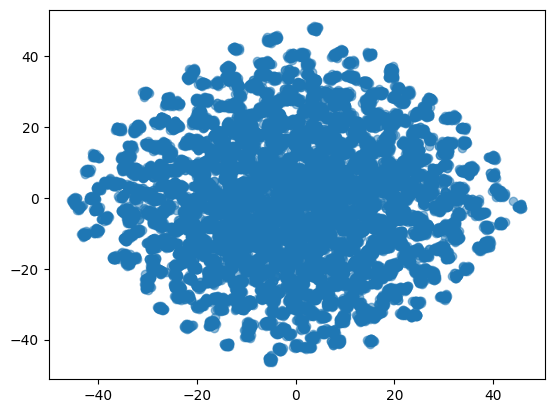

In [5]:
plt.scatter(data_projected.iloc[:, 0], data_projected.iloc[:, 1], alpha=0.5)

In [6]:
N_SAMPLES = 10000

indices = np.random.permutation(list(range(dataset.shape[0])))
dataset_sample = dataset.loc[indices[:N_SAMPLES],:]
data_projected_sample = np.take(data_projected, indices[:N_SAMPLES], axis=0)

In [10]:
agglo = AgglomerativeClustering(n_clusters=3)
labels = agglo.fit_predict(data_projected_sample).astype(str)

data_projected_sample["cluster"] = labels

In [11]:
plot_3d(data_projected_sample)

In [12]:
plot_2d(data_projected_sample)